### Install dependencies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sweetviz as sv
import plotly
import altair as alt

import warnings
warnings.filterwarnings('ignore')  # 경고 메시지 무시 

#### data load 

In [2]:
data = pd.read_csv("data.csv")
# Computer system 환경에 따라 encoding_error 발생 가능 

# NaN 값이 있는 열 제거 
data = data.dropna(axis=1)
data.head() 

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693


### Data 탐색 

In [3]:
data.info() 

# 결측값 없음
# object type : artists, id, name, release_date, tempo 

# 169847 샘플 / 18 특징 존재함 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169847 entries, 0 to 169846
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169847 non-null  float64
 1   artists           169847 non-null  object 
 2   danceability      169847 non-null  float64
 3   duration_ms       169847 non-null  int64  
 4   energy            169847 non-null  float64
 5   explicit          169847 non-null  int64  
 6   id                169847 non-null  object 
 7   instrumentalness  169847 non-null  float64
 8   key               169847 non-null  int64  
 9   liveness          169847 non-null  float64
 10  loudness          169847 non-null  float64
 11  mode              169847 non-null  int64  
 12  name              169847 non-null  object 
 13  popularity        169847 non-null  object 
 14  release_date      169847 non-null  object 
 15  speechiness       169847 non-null  float64
 16  tempo             16

### 데이터 전처리 

중복 데이터 제거

In [4]:
# 원본 데이터(data) 보존을 위해 복사본(df) 생성
df = data.copy()


# 데이터 크롤링 시 같은 노래인데 다른 버전(ex_ feat)의 노래도 포함된 것으로 보임. 
# 노래 제목과 가수가 같은 중복 노래 제거 
print(f"Before : {df.duplicated(['name']).sum()}, {data.shape}") # 중복 데이터 36908 존재
df.drop_duplicates(['name'], inplace=True, keep='first') # 첫 번째 데이터만 그대로 두고 제거 
print(f"After : {df.duplicated().sum()}, {df.shape}") # 중복데이터 제거 확인 => 132939 샘플


Before : 36903, (169847, 18)
After : 0, (132944, 18)


필요없는 column 삭제 

In [5]:
## audio feature 수치의 정량적 결과를 통해 EDA 진행할 예정이므로, 이외의 특성은 삭제
## 필요없는 column 제거하기
df.drop(['artists', 'id', 'name', 'release_date', 'popularity', \
    'explicit', 'key', 'mode'], axis=1, inplace=True)
df.columns  # 남은 columns 

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')

object형 데이터 처리 

In [6]:
# object형 데이터 전처리 => float 형으로 변환
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return 0.0

df['tempo'] = df['tempo'].apply(convert_to_float)


이상치 제거

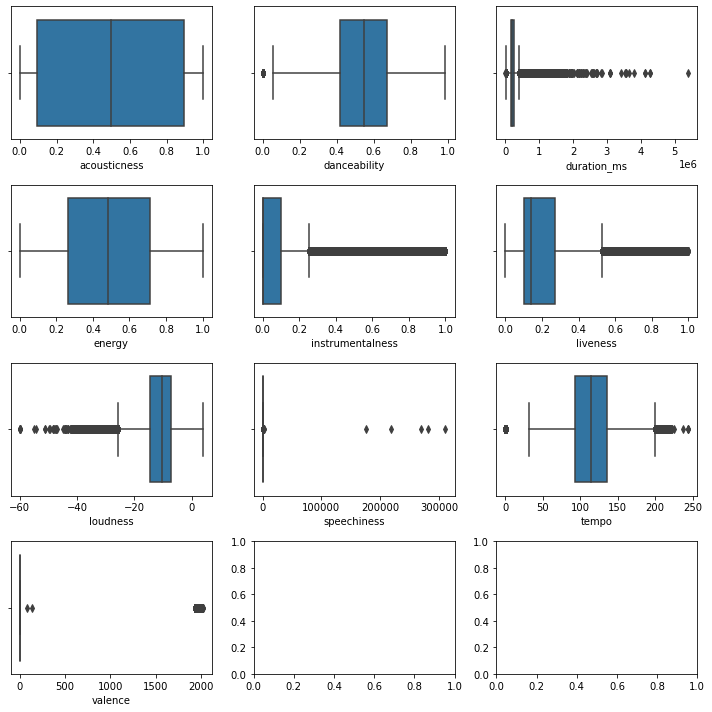

In [7]:
### 모든 feature에 대한 boxplot을 sns로 그려보기 
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
axes = axes.flatten()
ax_no = 0

for col in df.columns:
    sns.boxplot(data=df, x=col,ax=axes[ax_no])
    ax_no += 1
    
plt.tight_layout() 
plt.show()

# speechiness와 valence에 이상치값 확인됨. 

### 이상치 처리 

In [8]:
## 이상치 처리 : valence에 1.0 이상인 값을 모두 1.0으로 변환
df.loc[df['valence'] > 1.0, 'valence'] = 1.0

# speechiness도 0.66 이상인 값은 1.0으로 변환
df.loc[df['speechiness'] >= 0.66, 'speechiness'] = 0.66  # 0.66 이상이면 speech 높음 (공식 문서 참조)

df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,132944.000000,132944.000000,1.329440e+05,132944.000000,132944.000000,132944.000000,132944.000000,132944.000000,132944.000000,132944.000000
mean,0.495751,0.538500,2.312604e+05,0.488713,0.165723,0.211751,-11.438499,0.097133,116.434725,0.538024
std,0.378646,0.177059,1.256720e+05,0.267996,0.311786,0.182058,5.726578,0.133959,31.715216,0.264144
min,0.000000,0.000000,5.991000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000
25%,0.094700,0.416000,1.700830e+05,0.263000,0.000000,0.099200,-14.558000,0.035500,93.124000,0.329000
50%,0.495000,0.549000,2.077175e+05,0.481000,0.000233,0.138000,-10.497000,0.046400,114.614000,0.552000
75%,0.896000,0.670000,2.630000e+05,0.710000,0.102000,0.271000,-7.144000,0.081800,135.660250,0.756000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,3.855000,0.660000,244.091000,1.000000


In [9]:
# ## sweetviz로 간단하게 EDA 결과 확인 
# report = sv.analyze(df)
# report.show_html('report.html')
# # valence랑 comparasion해서 EDA한 결과 

데이터 시각화

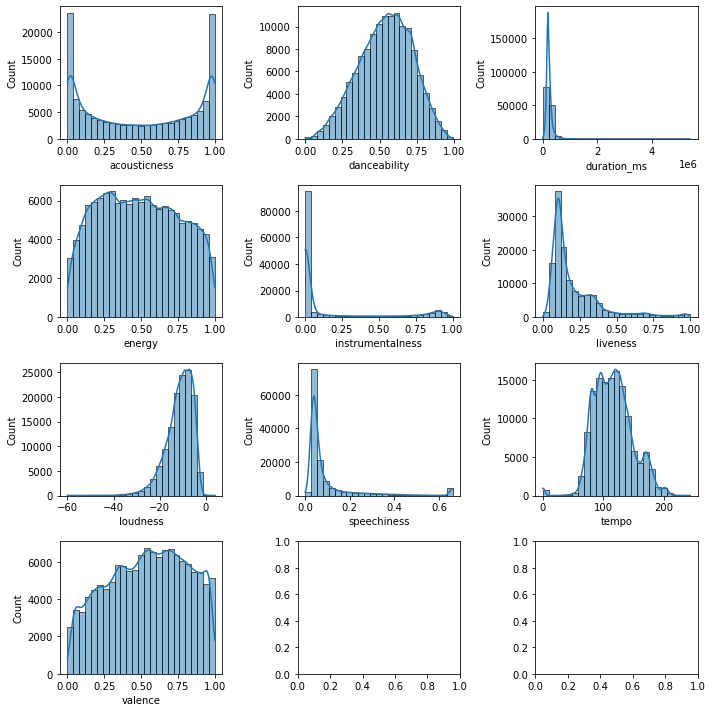

In [10]:
### 모든 feature에 대한 distplot을 sns로 그려보기 

num_cols = df.select_dtypes(include="number").columns

fig, axes = plt.subplots(4, 3, figsize=(10, 10))
axes = axes.flatten()
ax_no = 0

for col in num_cols:
    sns.histplot(data=df, x=col, bins=25, kde=True, ax=axes[ax_no])
    ax_no += 1
    
plt.tight_layout()  
plt.show()

상관관계 시각화 

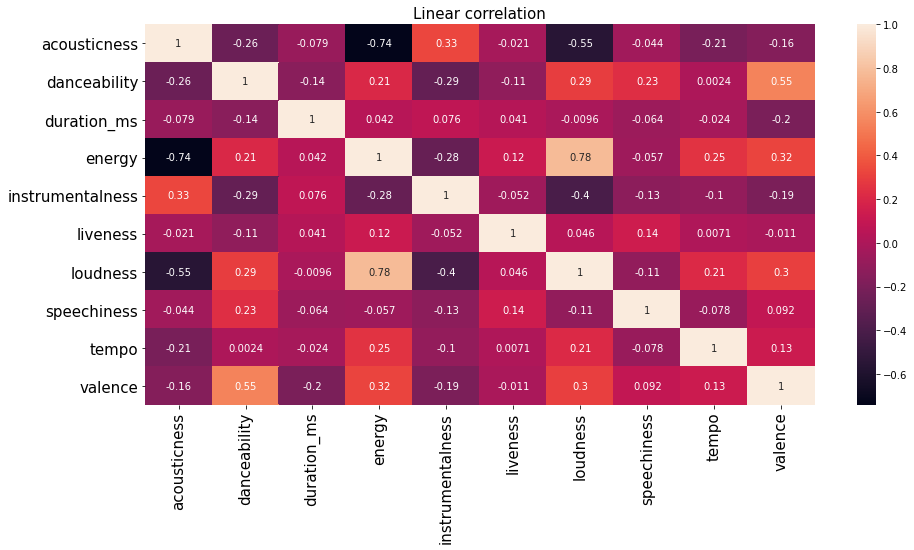

In [11]:
# feature간 상관관계 시각화

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True)
plt.title('Linear correlation', size=15)
ax.set_xticklabels(list(df.columns), size=15, rotation=90)
ax.set_yticklabels(list(df.columns), size=15, rotation=0);

In [12]:
# absolute 상관관계(spearman) 시각화
corr_df = df.corr('spearman').stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0  # Remove diagonal
corr_df['abs'] = corr_df['corr'].abs()

alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='abs',
    color=alt.Color('corr', scale=alt.Scale(scheme='blueorange', domain=(-1, 1)))
).properties(
    title={'text': 'Absolute Correlation', 'fontSize': 15},
    width=300,  
    height=300  
)


alt.Chart(...)

## Feature Engineering 

특성 추출 및 데이터 정규화
- 10개의 Audio Feature 중 주요한 특징을 추출하기 위해 PCA 진행 
- PCA 전에 특성 스케일링 진행

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E418C8B670>,
      dtype=object)

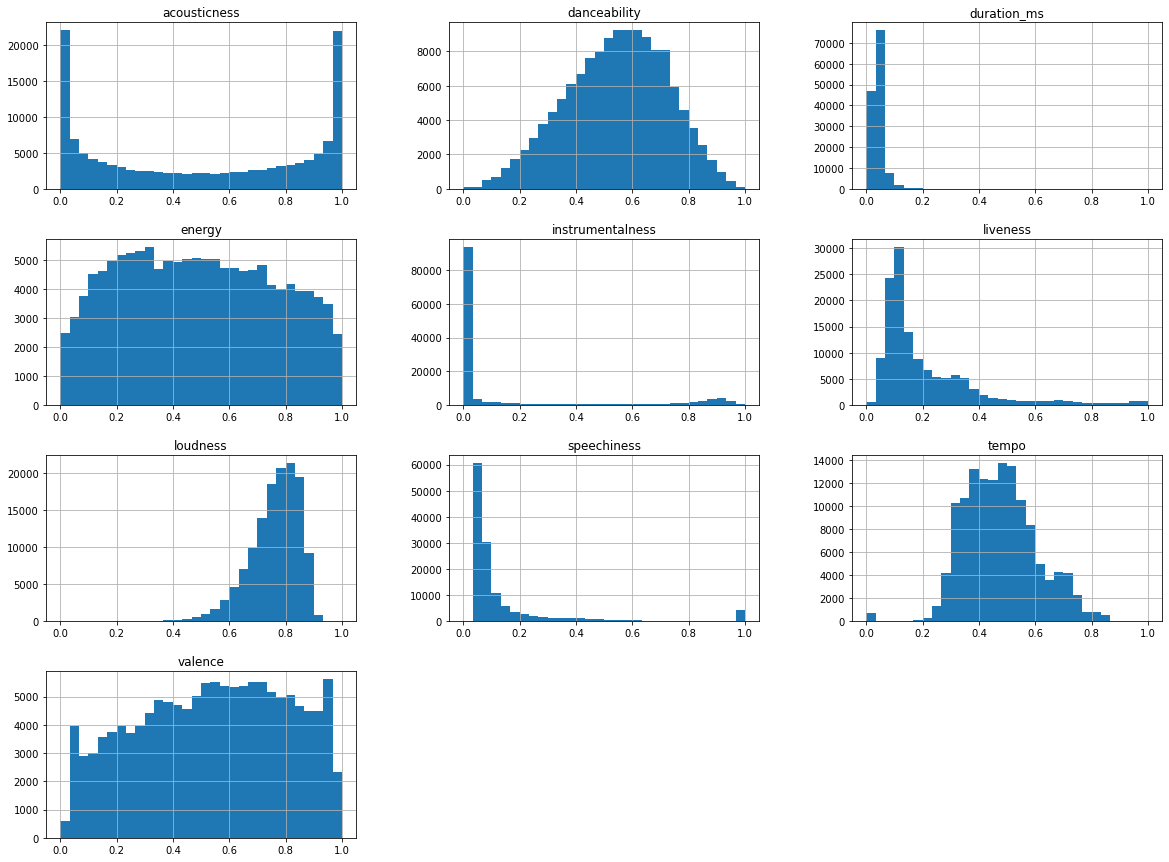

In [13]:
### 위의 결과를 바탕으로 주요한 특성들만 추출 (아무 특성과도 관계가 없는 특성들을 고려대상에서 제외)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 데이터 정규화 작업
#scaler = StandardScaler()
scaler = MinMaxScaler()  # 0-1 사이의 값으로 정규화

# 스케일링 작업 
scaled_val = scaler.fit_transform(df.values)

scaled_df = pd.DataFrame(scaled_val, index=df.index, columns=df.columns)

## 시각화 
scaled_df.hist(bins=30,figsize=(20,15))


### PCA (주성분분석)

In [14]:
from sklearn.decomposition import PCA

n_components = 5 # 주성분 개수 

pca = PCA(n_components=n_components)
pca.fit(scaled_df)
explained_variance_ratio = pca.explained_variance_ratio_

print(explained_variance_ratio.sum())  # 약 90% 설명력을 가짐

# 주성분에 대한 원래 특성의 가중치 출력
components = pd.DataFrame(
    pca.components_, columns=scaled_df.columns, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
print(components)


0.8980898014338283
     acousticness  danceability  duration_ms    energy  instrumentalness  \
PC1      0.734127     -0.155973    -0.000287 -0.477737          0.370293   
PC2     -0.414413     -0.285417     0.017531  0.197643          0.668325   
PC3      0.074344      0.254853    -0.010419  0.167180          0.607962   
PC4     -0.190476      0.146834     0.000749 -0.170326          0.192310   
PC5      0.261744     -0.290736     0.003241  0.366155         -0.028626   

     liveness  loudness  speechiness     tempo   valence  
PC1 -0.024055 -0.134514    -0.032878 -0.068992 -0.216488  
PC2  0.000252 -0.003267    -0.206780  0.022204 -0.466379  
PC3 -0.061168  0.020641    -0.010986  0.029412  0.725737  
PC4  0.261747 -0.103313     0.879302 -0.106902 -0.111262  
PC5  0.832147  0.081719    -0.036813  0.072641  0.079275  


In [15]:
## 주성분 추출에 쓰이는 특성들만 추출 
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer

features = scaled_df[['valence', 'energy', 'acousticness', 'danceability', 'instrumentalness']]
# Valence가 0.5 이상이면 1, 0.5 미만이면 0으로 분류 (자명한 사실)
features["pos"] = np.where(features["valence"] >= 0.6, 1, 0)


def compute_density_scores(data, num_components=10):
    gmm = GaussianMixture(n_components=num_components, random_state=0)
    gmm.fit(data)
    density_scores = np.exp(gmm.score_samples(data))
    return density_scores

# 데이터 샘플의 밀도 점수 계산 
density_scores = compute_density_scores(features)

# 가중치 계산
weights = 1 / (density_scores + 0.5)
weights /= np.sum(weights)

np.random.seed(42)
# 5000개 샘플링
indices = np.random.choice(features.shape[0], size=5000, replace=False, p=weights)
features = features.iloc[indices]

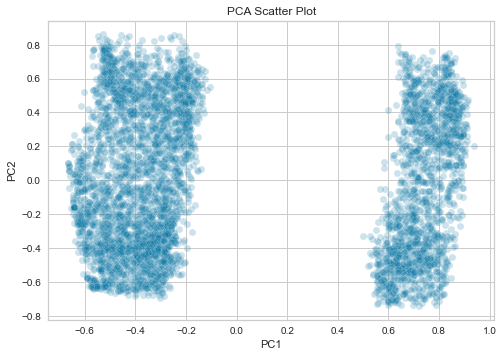

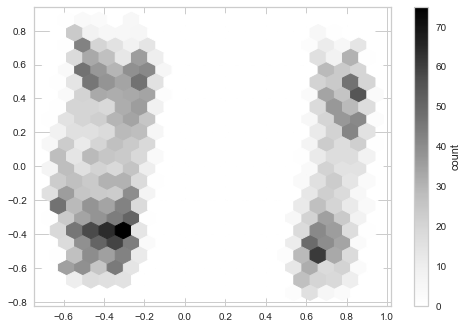

In [16]:
## 특성 추출 주성분 분석
from sklearn.decomposition import PCA

n_components = 2  # 주성분 2개로 설정하여 데이터 분포 시각화에 사용

pca = PCA(n_components=n_components)

# 주성분 분석에 필요한 파라미터를 학습시키고 변환
pca.fit(features)
pca_trans = pca.transform(features)

# 데이터를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_trans, columns=['PC1', 'PC2'])

# 시각화
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.2)
plt.title('PCA Scatter Plot')
plt.show()

# hexbin 시각화 => 데이터 밀집도
plt.hexbin(x=pca_df['PC1'], y=pca_df['PC2'], gridsize=20)
cb = plt.colorbar(label='count')

## 시각화 결과 주어진 데이터셋으로 4개의 클러스터를 나눠도 괜찮을 것같다!

## 클러스터링 

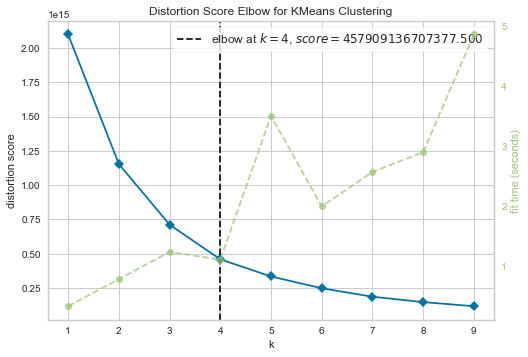

In [17]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Elbow method 사용
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))
visualizer.fit(df.values)
visualizer.show()

In [28]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(features)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

features['cluster'] = labels


val_rfm = features.assign(Cluster=labels)
group = val_rfm.groupby(["Cluster"])
group.agg({

    'danceability': 'mean', 'acousticness': 'mean', 'instrumentalness': 'mean', 
    'energy': 'mean', 'valence': 'mean',


}).round(1)


,danceability,acousticness,instrumentalness,energy,valence
Cluster,,,,,
0,0.6,0.1,0.5,0.7,0.8
1,0.5,0.1,0.5,0.6,0.3
2,0.4,0.8,0.5,0.4,0.3
3,0.5,0.9,0.5,0.4,0.8


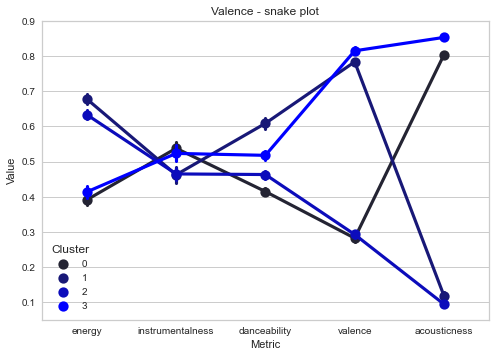

In [19]:
# Valence Plot
val_melt=pd.melt(val_rfm.reset_index(), id_vars =['Cluster'],value_vars=['energy','instrumentalness', 'danceability','valence', 'acousticness'],var_name='Metric',value_name='Value')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Valence - snake plot')
sns.pointplot(data=val_melt,x='Metric',y='Value' ,hue='Cluster', color='blue')


# 클러스터 해석 
# 클러스터 0 => HAPPY 
# 클러스터 1 => CALM, RELAXED 
# 클러스터 2 => SAD 
# 클러스터 3 => NERVOUS, ANGRY

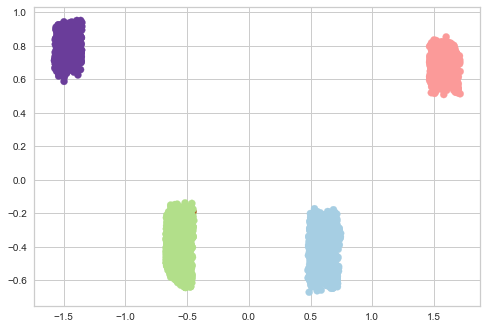

In [29]:

from sklearn.cluster import DBSCAN

# DBSCAN 클러스터링 수행
db = DBSCAN(eps=0.3, min_samples=1)
db.fit(features)
labels = db.labels_

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# 클러스터링 결과 시각화
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Paired')
plt.show()


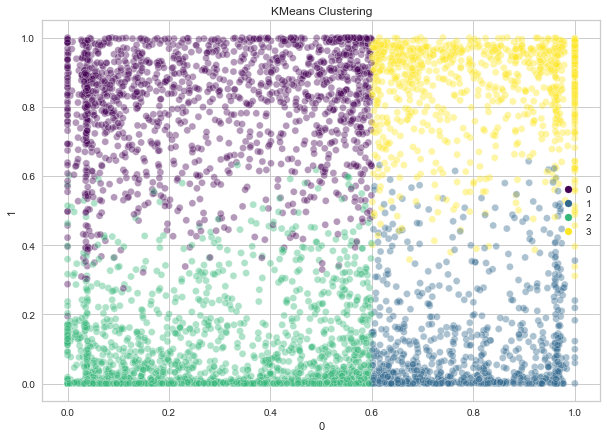

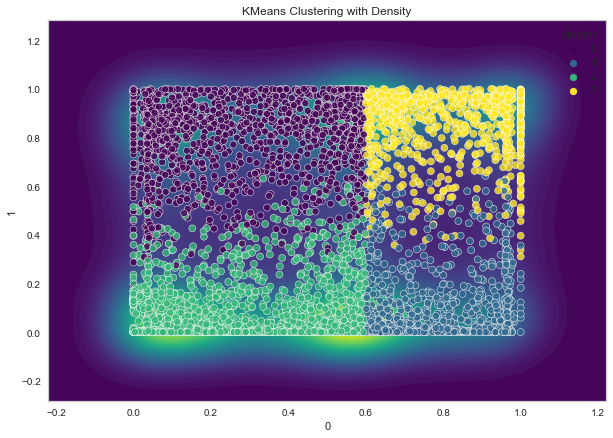

In [21]:
plt.figure(figsize=(10, 7))


plane = pd.concat([features['valence'], features['acousticness'], features['cluster']], axis=1)


plane.columns = [0, 1, "cluster"]
sns.scatterplot(plane[0], plane[1], hue = plane['cluster'], legend="full", palette='viridis', alpha=0.4)
plt.title("KMeans Clustering")
plt.legend()
plt.show()


##### 밀도와 함께 시각화
plt.figure(figsize=(10, 7))
# kdeplot으로 밀도 추정치 시각화 (커널 밀도 추정 사용 )
sns.kdeplot(plane[0], plane[1], fill=True, thresh=0, levels=100, cmap='viridis')
# 클러스터링 결과에 따라 색상을 다르게 지정한 scatter plot
sns.scatterplot(plane[0], plane[1], hue=plane['cluster'], legend="full", palette='viridis', alpha=0.8)

plt.title("KMeans Clustering with Density")
plt.show()


클러스터링 결과
-

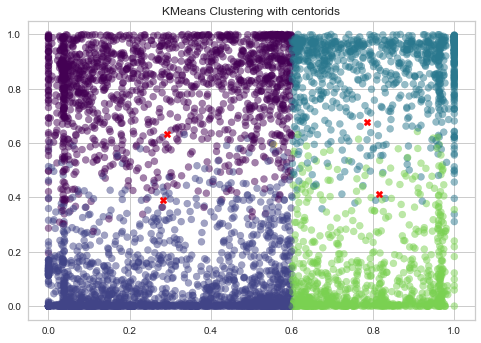

In [31]:
# 클러스터링 결과 시각화
plt.scatter(features['valence'], features['acousticness'], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X')
plt.title(f"Estimated number of clusters: {n_clusters}")
plt.title("KMeans Clustering with centorids")
plt.show()


In [32]:
print(centroids[:, 0])
print(centroids[:, 1])

[0.7839547  0.29213448 0.28168172 0.81542534]
[0.67807096 0.63341922 0.39088068 0.41347472]


In [24]:
# # 실루엣 계수 측정 (-1 ~ 1까지, 1에 가까울수록 좋음)

# 정량적 평가 결과로는 매우 좋은 수치. 
from sklearn import metrics 
sil_score = metrics.silhouette_score(features, features['cluster'])
print(f'실루엣 계수: {sil_score}')

# Calinski-Harabasz Index
index_score = metrics.calinski_harabasz_score(features, features['cluster'])
print(f'Calinski-Harabasz 지수: {index_score}')

실루엣 계수: 0.57828259185604
Calinski-Harabasz 지수: 8742.168111762874


In [25]:
import pickle

# PCA와 K-means 모델을 저장하기
with open('kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


In [36]:
###### 0.8

n_clusters = 4

test = features[['valence', 'acousticness']]
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(test)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

test['cluster'] = labels

sil_score = metrics.silhouette_score(test, test['cluster'])
print(f'실루엣 계수: {sil_score}')

print("샘플 개수")
print(test['cluster'].value_counts())  # 각 클러스터의 샘플 개수

print("센트로이드")
centroids = np.array(list(zip(centroids[:, 0], centroids[:, 1])))
print(centroids)


실루엣 계수: 0.7991611609315871
샘플 개수
3    1458
1    1335
0    1180
2    1027
Name: cluster, dtype: int64
센트로이드
[[0.1655862  0.08796138]
 [0.7281191  0.843921  ]
 [0.18056842 0.80277347]
 [0.67148181 0.10245991]]
